C:\Users\resh1\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\resh1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


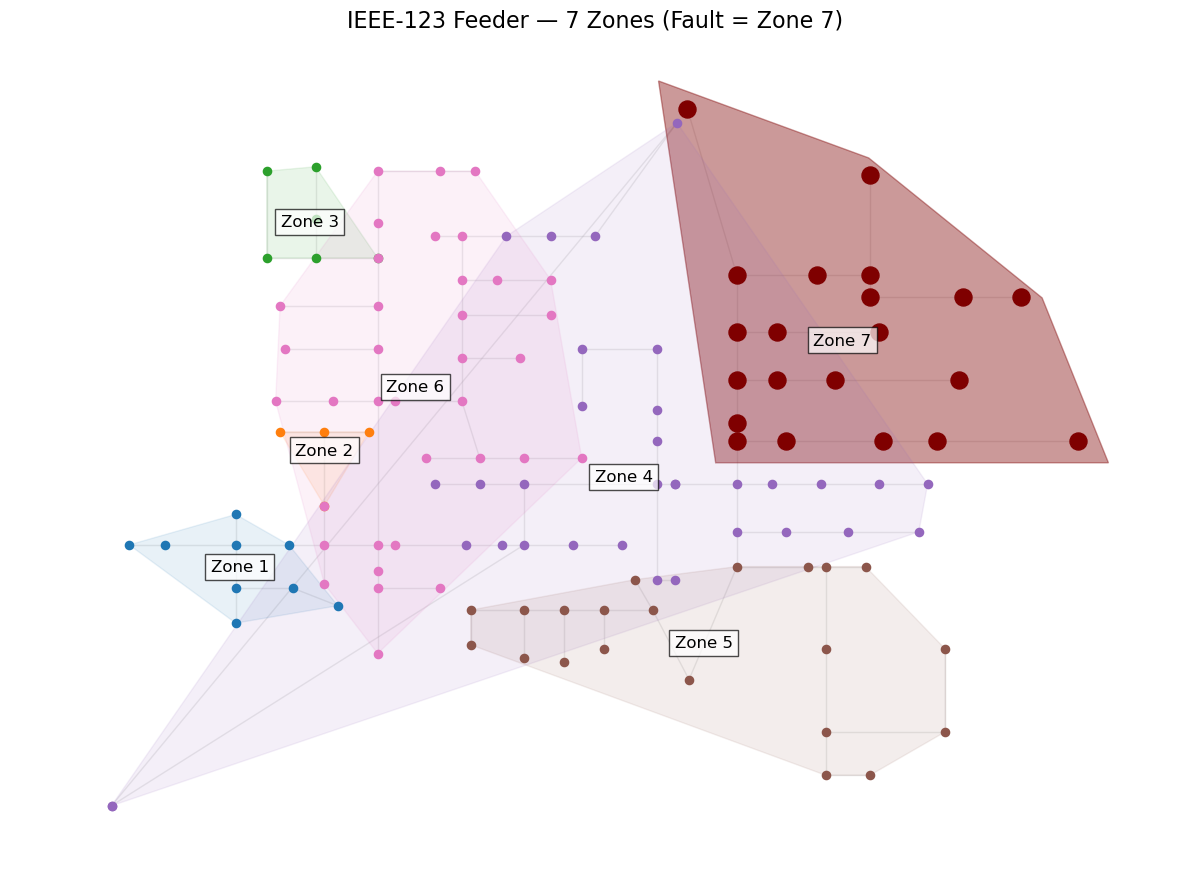

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from scipy.spatial import ConvexHull
from opendssdirect import dss

# 1. Clear and load feeder
dss.Command('ClearAll')
dss.Command(r'Redirect "C:\Users\resh1\OneDrive\Reshma2\LnT\IEEE123Bus\IEEE123Bus\IEEE123Master.dss"')
dss.Command('Solve')

# 2. Load bus coordinates
coords = pd.read_csv(
    r"C:\Users\resh1\OneDrive\Reshma2\LnT\IEEE123Bus\IEEE123Bus\BusCoords.dat",
    sep=r"[,\s]+", names=["Bus", "X", "Y"],
    index_col="Bus", engine="python"
)

# 3. Build adjacency graph
bus_map, edges, idx = {}, [], 0
ptr = dss.Lines.First()
while ptr != 0:
    b1 = dss.Lines.Bus1().split('.')[0]
    b2 = dss.Lines.Bus2().split('.')[0]
    for b in (b1, b2):
        if b not in bus_map:
            bus_map[b] = idx; idx += 1
    r = dss.Lines.R1()
    if r > 0:
        edges.append((bus_map[b1], bus_map[b2], 1.0 / r))
    ptr = dss.Lines.Next()

n = len(bus_map)
W = np.zeros((n, n))
for u, v, w in edges:
    W[u, v] = W[v, u] = w

# 4. Spectral clustering (7 zones)
k = 7
labels = SpectralClustering(n_clusters=k, affinity="precomputed", random_state=42).fit_predict(W)

# 5. Map coordinates (with fallback)
pos = {}
for bus, i in bus_map.items():
    b = bus.split('.')[0]
    if b in coords.index:
        pos[i] = (coords.at[b, "X"], coords.at[b, "Y"])

missing = [i for i in range(n) if i not in pos]
if missing:
    tmpG = nx.Graph()
    tmpG.add_edges_from([(u, v) for u, v, _ in edges])
    fallback = nx.spring_layout(tmpG, seed=42)
    for i in missing:
        pos[i] = fallback[i]

# 6. Zone colors & fault zone (Zone 7)
zone_cols = {
    0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c",
    3: "#9467bd", 4: "#8c564b", 5: "#e377c2",
    6: "#7f0000"
}
fault_zone = 6

# 7. Build plot graph
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_weighted_edges_from(edges)

plt.figure(figsize=(12, 9))
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="#aaa")

# Draw nodes by zone
for z in range(k):
    nds = [i for i in range(n) if labels[i] == z]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nds,
        node_color=[zone_cols[z]],
        node_size=(150 if z == fault_zone else 35)
    )

# Fill fault zone hull
pts = np.array([pos[i] for i in range(n) if labels[i] == fault_zone])
if pts.shape[0] >= 3:
    hull = ConvexHull(pts)
    center = pts[hull.vertices].mean(axis=0)
    inflated = center + 1.15 * (pts[hull.vertices] - center)
    plt.fill(*inflated.T, color=zone_cols[fault_zone], alpha=0.4)

# Fill other zones lightly
for z in range(k):
    if z == fault_zone: continue
    pts = np.array([pos[i] for i in range(n) if labels[i] == z])
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        plt.fill(*pts[hull.vertices].T, color=zone_cols[z], alpha=0.1)

# Add zone labels
for z in range(k):
    pts = np.array([pos[i] for i in range(n) if labels[i] == z])
    if pts.size:
        cx, cy = pts.mean(axis=0)
        plt.text(
            cx, cy, f"Zone {z+1}",
            fontsize=12, ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.7)
        )

plt.title(f"IEEE‑123 Feeder — 7 Zones (Fault = Zone {fault_zone+1})", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()
